In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
import datetime
import time
import matplotlib.pyplot as plt
import re
from unicodedata import normalize
import string

In [ ]:
path = '/news-headlines.tsv'

In [ ]:
def load_data(path, numbers):
    data = []
    with open(path, "r") as file:
      lines = csv.reader(file, delimiter='\t')
      for line in lines:
        hdln = line[1]
        data.append(hdln)
    return data[:numbers]

In [ ]:
numbers = 20000
data = load_data(path, numbers)

In [ ]:
def process_pairs(line):
    line = line.lower().strip()
    line = normalize('NFD' , line).encode('ascii' , 'ignore')
    line = line.decode('UTF-8')
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ",line)
    line = line.strip()
    return line

In [ ]:
data_processed = []
for text in data:
    data_processed.append(process_pairs(text))

In [ ]:
np.mean([len(s.split()) for s in data_processed])

11.3212

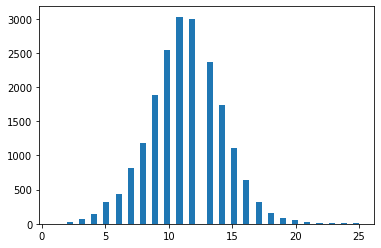

In [ ]:
plt.hist([len(s.split()) for s in data_processed], bins=50)
plt.show()

In [ ]:
max_len = 16 
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    padded = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')
    return padded, lang_tokenizer

In [ ]:
input_padded, inp_tokenizer = tokenize(data_processed)

In [ ]:
input_padded.shape

(20000, 16)

In [ ]:
# now convert to numpy array
np_data = np.array(input_padded)
# for training, we use one character shifted data
np_data_in = np_data[:, :-1]
np_data_out = np_data[:, 1:]

# Create TF dataset

##################
#### MODELING ####
##################

# Length of the vocabulary in chars
vocab_size = len(inp_tokenizer.word_index)+1

#batch size
BATCH_SIZE=256

# create tf.DataSet
BUFFER_SIZE = len(np_data_in)

dataset = tf.data.Dataset.from_tensor_slices((np_data_in, np_data_out)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
for x, y in dataset:
    print(x[0],'\n',y[0])
    break

tf.Tensor(
[  172   814     4  3092   351     4   318   118     6  1918 10549   516
    39    79  2981], shape=(15,), dtype=int32) 
 tf.Tensor(
[  814     4  3092   351     4   318   118     6  1918 10549   516    39
    79  2981     0], shape=(15,), dtype=int32)


In [ ]:
stop = inp_tokenizer.word_index['.']

In [ ]:
#########################
# Positional Encoder
#########################

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])


    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#########################
# Mask Calculations
#########################
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, x)

In [ ]:
#########################
# Attention
#########################
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.wq = tf.keras.layers.Dense(self.head_dim)
        self.wk = tf.keras.layers.Dense(self.head_dim)
        self.wv = tf.keras.layers.Dense(self.head_dim)
        self.dense = tf.keras.layers.Dense(self.embed_size)


    def call(self, v, k, q, mask):
        # Get number of training examples
        batch_size = q.shape[0]

        seq_len_v, seq_len_k, seq_len_q = v.shape[1], k.shape[1], q.shape[1]


        # Split the embedding into self.heads different pieces
        v = tf.reshape(v,(batch_size,seq_len_v, self.heads, self.head_dim))
        k = tf.reshape(k,(batch_size,seq_len_k, self.heads, self.head_dim))
        q = tf.reshape(q,(batch_size,seq_len_q, self.heads, self.head_dim))


        values = self.wv(v)  # (batch_size, value_len, heads, head_dim)
        keys = self.wk(k)  # (batch_size, key_len, heads, head_dim)
        queries = self.wq(q)  # (batch_size, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example

        attention = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        # queries shape: (batch_size, seq_len_q, heads, heads_dim),
        # keys shape: (batch_size, seq_len_k, heads, heads_dim)
        # attention: (batch_size, heads, seq_len_q, seq_len_k)

         # scale matmul_qk
        dk = tf.cast(tf.shape(keys)[1], tf.float32)
        scaled_attention_logits = attention / tf.math.sqrt(dk)

        # Mask padded indices so their weights become 0

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # attention shape: (batch_size, heads, seq_len_q, seq_len_k)



        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (batch_size, seq_len_q, -1))
        # attention shape: (batch_size, heads, seq_len_q, key_len)
        # values shape: (batch_size, seq_len_v, heads, heads_dim)
        # out after matrix multiply: (batch_size, seq_len_q, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.dense(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out, attention_weights

#########################
# Feed Forward Layer
#########################
def point_wise_feed_forward_network(embed_size, feed_forward):
    return tf.keras.Sequential([
        # (batch_size, seq_len, feed_forward)
        tf.keras.layers.Dense(feed_forward, activation='relu'),
        tf.keras.layers.Dense(embed_size)  # (batch_size, seq_len, embed_size)
    ])


In [ ]:
#########################
# Decoder
#########################
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads, feed_forward, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha = MultiHeadAttention(embed_size, heads)

        self.ffn = point_wise_feed_forward_network(embed_size, feed_forward)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training,look_ahead_mask):
        # enc_output.shape == (batch_size, input_seq_len, embed_size)
        attn, attn_weights_block = self.mha(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, embed_size)
        attn = self.dropout1(attn, training=training)
        out = self.layernorm1(attn + x) # residual

        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, embed_size)
        ffn_output = self.dropout2(ffn_output, training=training)
        # (batch_size, target_seq_len, embed_size)
        out = self.layernorm2(ffn_output + out)

        return out, attn_weights_block
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embed_size, input_vocab_size, heads, feed_forward,    pe_input, rate=0.1):
    super(Decoder, self).__init__()

    self.embed_size = embed_size
    self.num_layers = num_layers
    self.rate = rate

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, embed_size)    
    self.pos_encoding = positional_encoding(pe_input, embed_size)

    self.dec_layers = [DecoderLayer(embed_size, heads, feed_forward, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training,look_ahead_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):

      x, block = self.dec_layers[i](x, training, look_ahead_mask)

      attention_weights[f'decoder_layer{i+1}_block'] = block
    # x.shape == (batch_size, target_seq_len, embed_size)
    return x, attention_weights

In [ ]:
##################################################
# Transformer
##################################################
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, embed_size, heads, feed_forward, input_vocab_size, pe_input, rate=0.1):
    super(Transformer, self).__init__()

    self.decoder = Decoder(num_layers, embed_size, input_vocab_size, heads, feed_forward, pe_input, rate)

    self.Final_layer = tf.keras.layers.Dense(input_vocab_size, name='Final_layer')

  def call(self, inp, training):

    look_ahead_mask = create_look_ahead_mask(tf.shape(inp)[1])
    target_padding_mask = create_padding_mask(inp)
    look_ahead_mask = tf.maximum(target_padding_mask, look_ahead_mask)

    output, attention_weights = self.decoder(inp, training, look_ahead_mask)  # (batch_size, inp_seq_len, embed_size)
    out = self.Final_layer(output)

    return out, attention_weights

In [ ]:
num_layers = 4
embed_size = 128
feed_forward = embed_size*2
heads = 4
rate = 0.1
input_vocab_size = vocab_size
pe_input = 10000 #10000

In [ ]:
model = Transformer(num_layers, embed_size, heads, feed_forward, input_vocab_size, pe_input, rate=rate)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
                                     epsilon=1e-9)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
@tf.function
def train_step(inp, tar):
  with tf.GradientTape() as tape:
    output, _ = model(inp, True)
    loss = loss_object(tar, output)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_accuracy.update_state(tar, output)
  return loss

In [ ]:
EPOCHS = 10
history = {
  "epoch": [],
  "loss": [],
  "Accuracy": []
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
#  train_loss.reset_states()
  for (batch, (inp, tar)) in enumerate(dataset):
    batch_loss = train_step(inp, tar)
    total_loss = total_loss+batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batch+1))
  history['Accuracy'].append(train_accuracy.result())

  if (epoch+1) % 500 == 0:
      ckpt_save_path = ckpt_manager.save()
  if (epoch+1) % 10 == 0:    
    print(f'Epoch {epoch + 1} Loss {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 10 Loss 0.2841, Accuracy: 0.9220
Time taken for 1 epoch: 5.54 secs



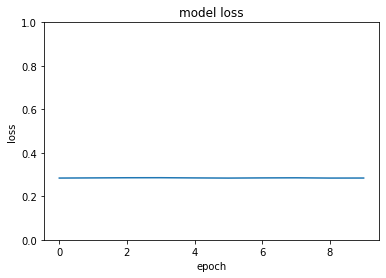

In [ ]:
# Plot accuracies
plt.plot(history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.xlim([1500, 4800])
plt.ylim([0, 1])
plt.show()

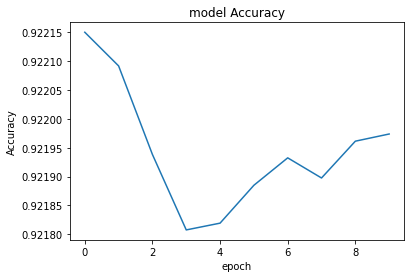

In [ ]:
plt.plot(history['Accuracy'])
plt.title('model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def generate_text(model, start_string, temperature=0.2, num_generate=15):
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  start_string = process_pairs(start_string)
  # Converting our start string to numbers (vectorizing)
  input_eval = [inp_tokenizer.word_index[i]  for i in start_string.split(' ')]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = ' '

  # Here batch size == 1
  for i in range(num_generate):
      predictions, _ = model(input_eval, False)
      # remove the batch dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
      predictions = tf.squeeze(predictions, 0)
      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature

      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      if predicted_id == 0:
         predicted_id = stop
      input_eval = tf.concat([input_eval, [[predicted_id]]], axis=-1)
      text_generated += inp_tokenizer.index_word[predicted_id] + ' '

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string=u"outlook"))

outlook should be trying to make common common . you re trying to be missed . 
